In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import call_gpt
from openai import OpenAI
from matplotlib.patches import FancyArrowPatch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from apikey import api_key
from IPython.display import Markdown, display
from highlight_text import ax_text, fig_text
def printmd(string):
    display(Markdown(string))

df = pd.read_csv('fake_and_real_news.csv')
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [158]:
client = OpenAI(api_key=api_key)

subset = df.sample(1000)

preds = []
preds_bool = []
is_correct = []

for row in tqdm(subset.iterrows()):
    prompt = row[1]['Text']
    real = row[1]['label']
    real_bool = True if real == 'Real' else False
    
    pred = call_gpt(client, prompt)
    pred_bool = True if pred == "Yes" else False

    preds.append(pred)
    preds_bool.append(pred_bool)
    is_correct.append(real_bool == pred_bool)

    print_output = False
    if print_output:
        printmd("<hr><br>")
        printmd(f"News: {prompt}")
        printmd(f"Model prediction: **{pred}**")
        printmd(f"Real label: **{real}**. Model prediction: **{pred}**")
    
        printmd(f"Correct: **{real_bool == pred_bool}**")

subset['pred'] = preds
subset['pred_bool'] = preds_bool
subset['is_correct'] = is_correct
subset['label_bin'] = subset['label'].map({'Fake': 0, 'Real': 1})
subset['pred_bin'] = subset['pred'].map({'No': 0, 'Yes': 1})

filter = subset['pred'].isin(['Yes', 'No'])
n_before = subset.shape[0]
subset = subset[filter]
n_after = subset.shape[0]

print(f"Filtered out {n_before - n_after} rows")

subset.to_csv('predictions.csv', index=False)

0it [00:00, ?it/s]

1000it [09:12,  1.81it/s]

Filtered out 47 rows


In [300]:
subset = pd.read_csv('predictions.csv')
repartition = round(subset['label'].value_counts(normalize=True)*100,1)
real_prop = repartition['Real']
fake_prop = repartition['Fake']

50.2

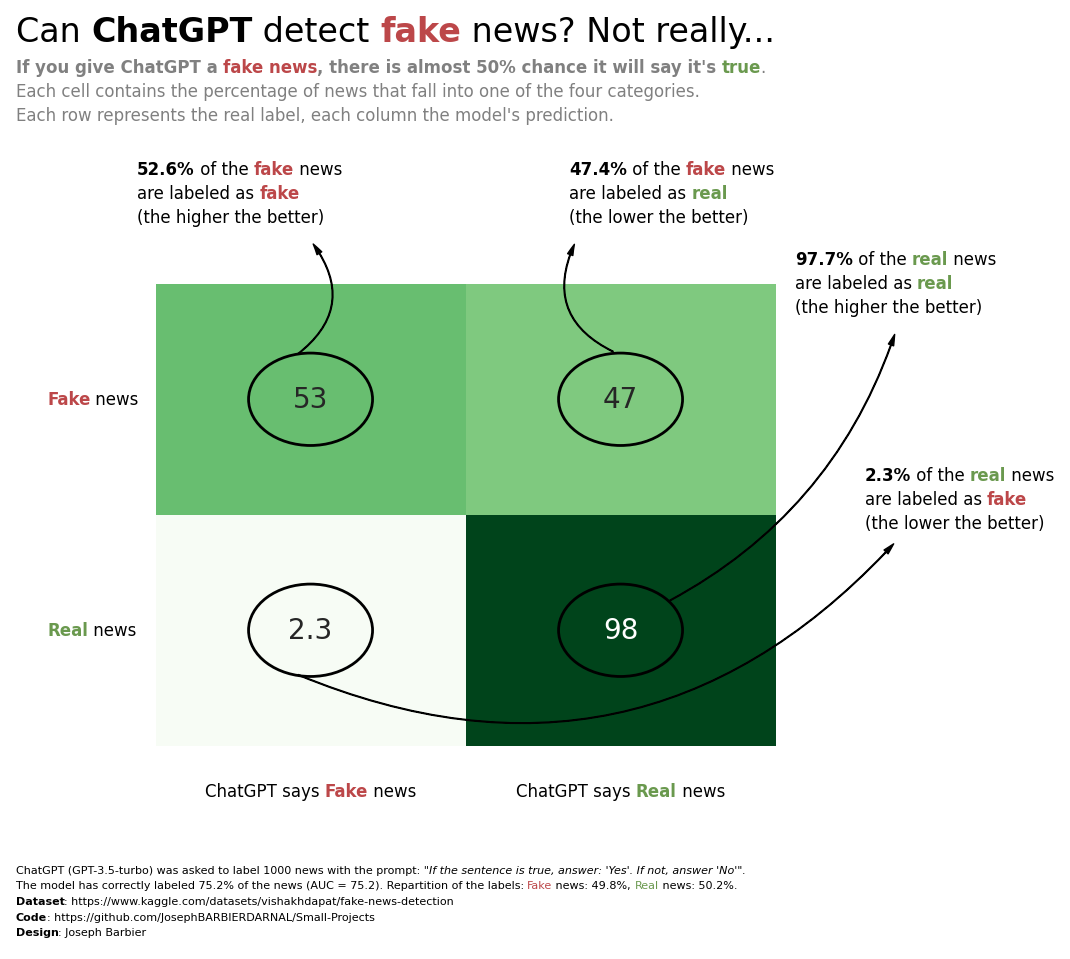

In [305]:
subset = pd.read_csv('predictions.csv')
repartition = round(subset['label'].value_counts(normalize=True)*100,1)

real_prop = repartition['Real']
fake_prop = repartition['Fake']

red = "#bc4749"
green = "#6a994e"

cm = confusion_matrix(subset['label_bin'], subset['pred_bin'], normalize='true')*100
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp = round(tn,1), round(fp,1), round(fn,1), round(tp,1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap='Greens',
    ax=ax,
    cbar=False,
    linewidth=0,
    linecolor='black',
    annot_kws={"size": 20}
)

# remove ticks
ax.set_yticks([])
ax.set_xticks([])

ax_text(
    -0.35, 0.5,
    "<Fake> news",
    ha='left', va='center',
    fontsize=12,
    ax=ax,
    highlight_textprops=[
        {'color': red,
         'weight': 'bold'}
    ]
)
ax_text(
    -0.35, 1.5,
     "<Real> news",
    ha='left', va='center',
    fontsize=12,
    ax=ax,
    highlight_textprops=[
        {'color': green,
         'weight': 'bold'}
    ]
)
ax_text(
    0.5, 2.2,
    "ChatGPT says <Fake> news",
    ha='center', va='center',
    fontsize=12,
    ax=ax,
    highlight_textprops=[
        {'color': red,
         'weight': 'bold'}
    ]
)
ax_text(
    1.5, 2.2,
    "ChatGPT says <Real> news",
    ha='center', va='center',
    fontsize=12,
    ax=ax,
    highlight_textprops=[
        {'color': green,
         'weight': 'bold'}
    ]
)

# title
text = "Can <ChatGPT> detect <fake> news? Not really..."
fig_text(
    -0.05, 1.3,
    text,
    ha='left', va='center',
    fontsize=24,
    highlight_textprops=[
        {'color': 'black',
         'weight': 'bold'},
        {'color': red,
         'weight': 'bold'},   
    ],
)

# subtitle
text = """
<If you give ChatGPT a> <fake news><, there is almost 50% chance it will say it's> <true>.
Each cell contains the percentage of news that fall into one of the four categories.
Each row represents the real label, each column the model's prediction.
"""
fig_text(
    -0.05, 1.2,
    text,
    ha='left', va='center',
    fontsize=12,
    color='grey',
    highlight_textprops=[
        {"weight":"bold"},
        {"weight":"bold","color":red},
        {"weight":"bold"},
        {"weight":"bold","color":green}
    ]
)

# credit at the end
acc = round(accuracy_score(subset['label_bin'], subset['pred_bin'])*100, 1)
auc = round(roc_auc_score(subset['label_bin'], subset['pred_bin'])*100, 1)
text = f"""
ChatGPT (GPT-3.5-turbo) was asked to label 1000 news with the prompt: "<If the sentence is true, answer: 'Yes'. If not, answer 'No'".>
The model has correctly labeled {acc}% of the news (AUC = {auc}). Repartition of the labels: <Fake> news: {fake_prop}%, <Real> news: {real_prop}%.
<Dataset>: https://www.kaggle.com/datasets/vishakhdapat/fake-news-detection
<Code>: https://github.com/JosephBARBIERDARNAL/Small-Projects
<Design>: Joseph Barbier
"""
fig_text(
    -0.05, -0.15,
    text,
    ha='left', va='center',
    fontsize=8,
    highlight_textprops=[
        {'style': 'italic'},
        {'color': red},
        {'color': green},
        {'weight': 'bold'},
        {'weight': 'bold'},
        {'weight': 'bold'},
    ],
)

# add OpenAI logo
openai_logo = np.array(Image.open('openai.webp'))
ax_image = fig.add_axes(
    [0.65, 1.27, 0.06, 0.06],
    anchor='SE',
    zorder=10
)
#ax_image.imshow(openai_logo)
ax_image.axis('off')

# add circles
def add_circle(ax, xy, radius=0.2, color='black'):
    circle = plt.Circle(xy, radius, color=color, fill=False, lw=2)
    ax.add_patch(circle)
add_circle(ax, (0.5, 0.5))
add_circle(ax, (1.5, 0.5))
add_circle(ax, (0.5, 1.5))
add_circle(ax, (1.5, 1.5))

# add arrows
def draw_arrow(tail_position, head_position, invert=False, rad=0.5):
    kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color="k")
    if invert:
        connectionstyle = f"arc3,rad=-{rad}"
    else:
        connectionstyle = f"arc3,rad={rad}"
    a = FancyArrowPatch(tail_position, head_position,
                        connectionstyle=connectionstyle,
                        transform=fig.transFigure,
                        zorder=3,
                        **kw)
    fig.patches.append(a)

draw_arrow((0.3, 0.76), (0.32, 0.95))
draw_arrow((0.7, 0.765), (0.65, 0.95), invert=True)
draw_arrow((0.3, 0.23), (1.05, 0.45), rad=0.35)
draw_arrow((0.765, 0.35), (1.05, 0.8), rad=0.2)

# text explaining arrows
fig_text(
    0.23, 1.03,
    f"<{tn}%> of the <fake> news\nare labeled as <fake>\n(the higher the better)",
    ha='center', va='center',
    fontsize=12,
    color='black',
    highlight_textprops=[
        {'weight': 'bold'},
        {'color': red, 'weight': 'bold'},
        {'color': red, 'weight': 'bold'},
    ]
)
fig_text(
    0.77, 1.03,
    f"<{fp}%> of the <fake> news\nare labeled as <real>\n(the lower the better)",
    ha='center', va='center',
    fontsize=12,
    color='black',
    highlight_textprops=[
        {'weight': 'bold'},
        {'color': red, 'weight': 'bold'},
        {'color': green, 'weight': 'bold'},
    ]
)
fig_text(
    1.05, 0.88,
    f"<{tp}%> of the <real> news\nare labeled as <real>\n(the higher the better)",
    ha='center', va='center',
    fontsize=12,
    color='black',
    highlight_textprops=[
        {'weight': 'bold'},
        {'color': green, 'weight': 'bold'},
        {'color': green, 'weight': 'bold'},
    ]
)
fig_text(
    1.13, 0.52,
    f"<{fn}%> of the <real> news\nare labeled as <fake>\n(the lower the better)",
    ha='center', va='center',
    fontsize=12,
    color='black',
    highlight_textprops=[
        {'weight': 'bold'},
        {'color': green, 'weight': 'bold'},
        {'color': red, 'weight': 'bold'},
    ]
)


fig.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josephbarbier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/josephbarbier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/josephbarbier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_40082/2010298311.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_40082/2010298311.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


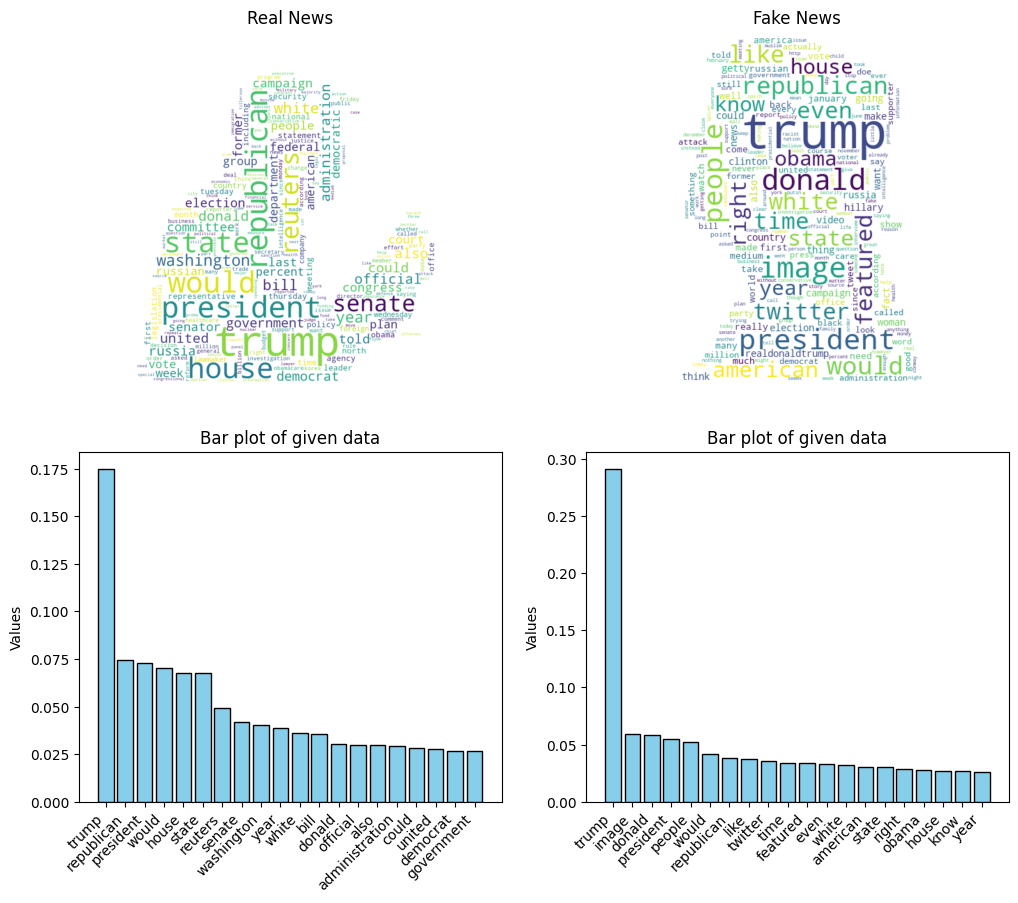

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import numpy as np
from utils import count_words, clean_text

df = pd.read_csv('fake_and_real_news.csv')
trump = np.array(Image.open('trump.png'))
trump2 = np.array(Image.open('trump2.png'))

fake_news = df[df['label'] == 'Fake']
fake_all_text = ' '.join(fake_news['Text'].values)

real_news = df[df['label'] == 'Real']
real_all_text = ' '.join(real_news['Text'].values)

def clean_and_count(text, n):
    return count_words(clean_text(text), n)

n = 1000
real_words = clean_and_count(real_all_text, n)
fake_words = clean_and_count(fake_all_text, n)


def add_barplot_to_axis(data_dict, ax, keep_n=20, relative=True):
    data_dict = dict(sorted(data_dict.items(), key=lambda x: x[1], reverse=True)[:keep_n])
    if relative:
        total = sum(data_dict.values())
        data_dict = {k: v / total for k, v in data_dict.items()}
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    ax.bar(labels, values, color='skyblue', edgecolor='black', linewidth=1)
    ax.set_ylabel('Values')
    ax.set_title('Bar plot of given data')
    ax.set_xticklabels(labels, rotation=45, ha='right')

width, height = 600, 400
real = WordCloud(width=width, height=height, mask=trump, background_color='white')
fake = WordCloud(width=width, height=height, mask=trump2, background_color='white')
real.generate_from_frequencies(real_words)
fake.generate_from_frequencies(fake_words)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
ax = ax.flatten()

# wordclouds
ax[0].imshow(real, interpolation='bilinear')
ax[0].set_title('Real News')
ax[0].axis("off")
ax[1].imshow(fake, interpolation='bilinear')
ax[1].set_title('Fake News')
ax[1].axis("off")

# barplots
add_barplot_to_axis(real_words, ax[2])
add_barplot_to_axis(fake_words, ax[3])

plt.show()